In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
import pathlib

import numpy as np
import pandas as pd
import torch
import torchinfo
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', FutureWarning)

In [6]:
samples_path = pathlib.Path("../samples/tsdr_anomaly_patterns/labeled_tsdr_anomaly_patterns_20221202-024759.jsonl")
samples_df: pd.DataFrame = pd.read_json(str(samples_path), orient='records', lines=True)
samples_df.describe()

,dataset_id,target_app,chaos_type,chaos_comp,metric,time_series,anomaly_pattern,anomaly_position
count,1193,1193,1193,1193,1193,1193,1193,1193
unique,1,1,3,10,821,1172,15,3
top,qknmc,sock-shop,pod-memory-hog,catalogue,n-gke-meltria-sockshop-01-default-pool-cf9d09e...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",White noise,anomaly_during_fault
freq,1193,1193,524,202,7,3,267,519


In [30]:
tss = np.array([item for item in samples_df.loc[:, "time_series"].sample(n=10).reset_index(drop=True)])
random_sampled_df = pd.DataFrame(tss).T
random_sampled_df

,0,1,2,3,4,5,6,7,8,9
0,0.0000,4.0,1696.0,2260992.0,0.1833,0.0,5.485724e+09,0.0,3.857318e+09,1.668551e+09
1,0.0000,4.0,1696.0,2260992.0,0.1833,0.0,5.486981e+09,0.0,3.857318e+09,1.668551e+09
2,0.0000,4.0,1696.0,2260992.0,0.1833,0.0,5.486756e+09,0.0,3.857318e+09,1.668551e+09
3,0.0000,4.0,1696.0,2260992.0,0.1833,0.0,5.485736e+09,0.0,3.857318e+09,1.668551e+09
4,0.0000,4.0,1696.0,2260992.0,0.1833,0.0,5.484143e+09,0.0,3.857318e+09,1.668551e+09
...,...,...,...,...,...,...,...,...,...,...
175,0.0444,4.0,1696.0,2260992.0,0.2833,0.0,5.531349e+09,0.0,3.840680e+09,3.337107e+09
176,0.0444,3.0,1664.0,2260992.0,0.2500,0.0,5.531419e+09,0.0,3.845329e+09,3.337107e+09
177,0.0444,3.0,1696.0,2260992.0,0.2333,0.0,5.531087e+09,0.0,3.848516e+09,3.337107e+09
178,0.0000,3.0,1696.0,2260992.0,0.2000,0.0,5.530378e+09,0.0,3.850179e+09,3.337107e+09


array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

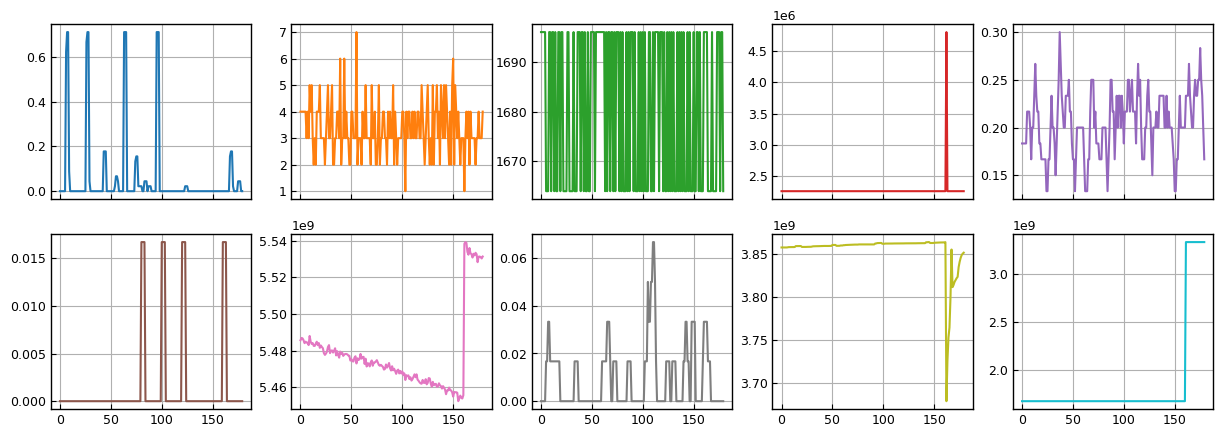

In [37]:
random_sampled_df.plot(figsize=(15, 5), legend=False, subplots=True, layout=(2, 5))

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

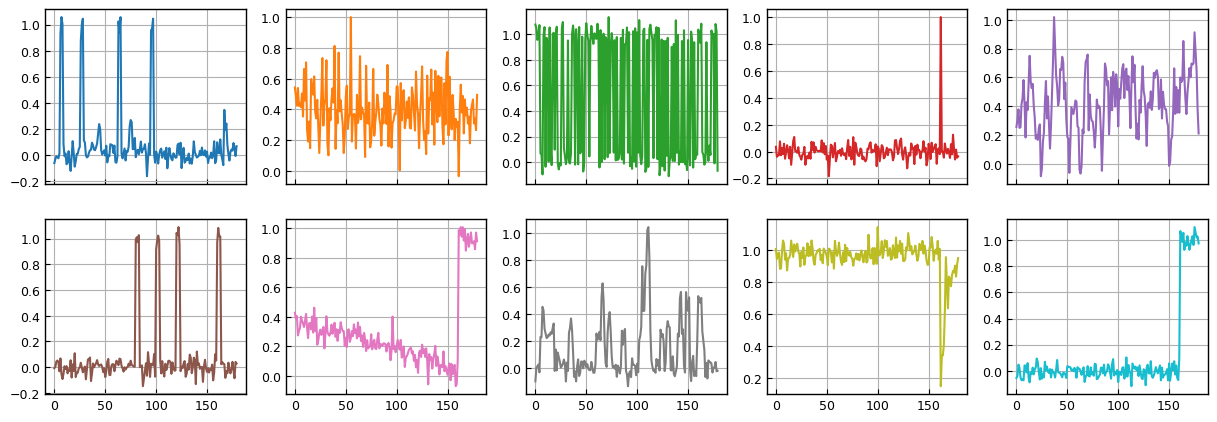

In [65]:
def add_noise(x, mu=.0, std=.05):
    # min/max normalization
    min, max = x.min(), x.max()
    nz_x = (x-min)/(max-min)
    noise = np.random.normal(mu, std, size = nz_x.shape)
    return nz_x + noise
    
random_sampled_df.apply(add_noise).reset_index(drop=True).plot(figsize=(15, 5), legend=False, subplots=True, layout=(2, 5))

## Reverse

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

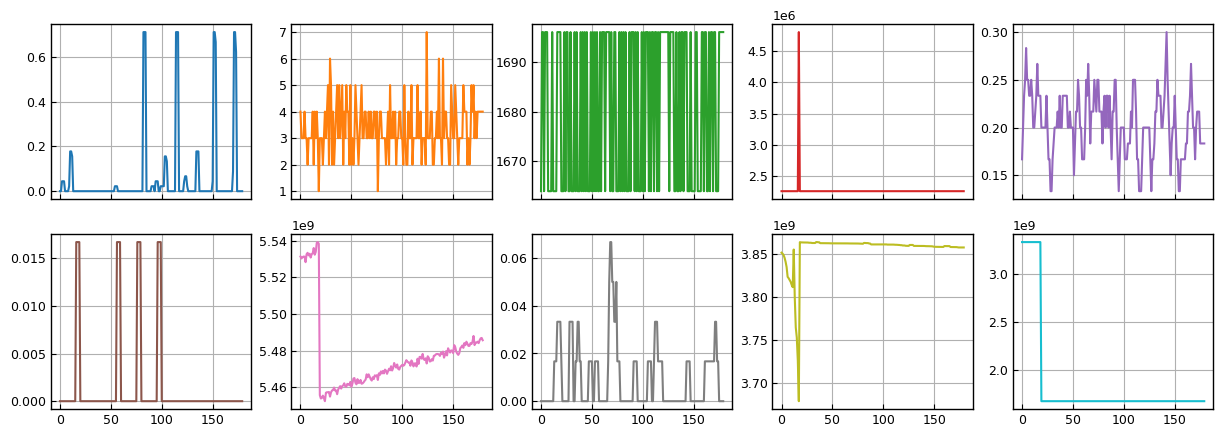

In [62]:
## horizontal reverse
random_sampled_df.apply(lambda x: x[::-1]).reset_index(drop=True).plot(figsize=(15, 5), legend=False, subplots=True, layout=(2, 5))

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

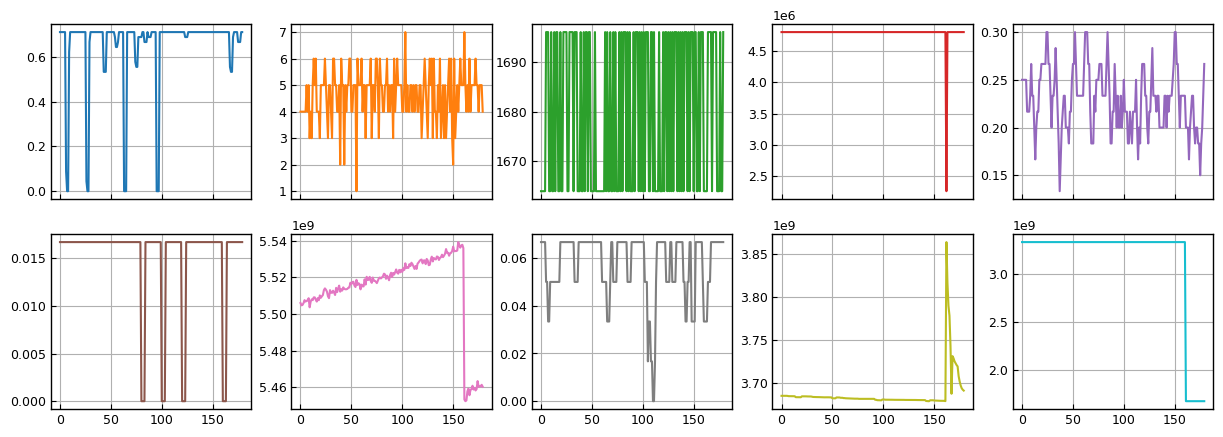

In [63]:
## vertical reverse
def flip_vertically(x):
    center = (np.max(x) + np.min(x))/2 
    _x = np.full_like(x, 0.0)
    for i in range(len(x)):
        _x[i] = center - (x[i] - center)
    return _x
    
random_sampled_df.apply(flip_vertically).reset_index(drop=True).plot(figsize=(15, 5), legend=False, subplots=True, layout=(2, 5))

## Shift

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

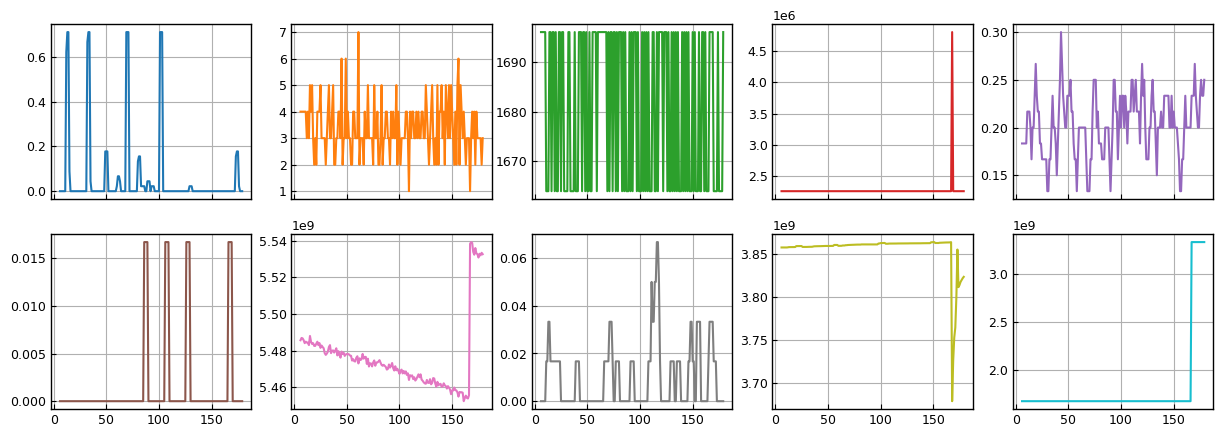

In [67]:
random_sampled_df.shift(6, axis=0).reset_index(drop=True).plot(figsize=(15, 5), legend=False, subplots=True, layout=(2, 5))

## Augumenting samples

rules / without anomaly position

1. Add noise -> no change of patterns
2. Reverse
   1. horizontal reverse
      1. Level shift up <-> Level shift down
      2. Steady increase <-> Steady decrease
      3. Sudden increase -> Sudden decrease
   2. vertical reverse
      1. Level shift up <-> Level shift down
      2. Steady increase <-> Steady decrease
      3. Sudden increase <-> Sudden decrease
      4. Single spike <-> Single dip
      5. Multiple spikes <-> Multiple dips
      6. Transient level shift up <-> Transient level shift down
3. Shift -> change anomaly position

In [97]:
samples_df["DA/noise"] = False
samples_df["DA/va_reverse"] = False
samples_df["DA/ha_reverse"] = False

In [98]:
## noise
noisy_samples_df = samples_df.copy()
noisy_samples_df.drop(columns="anomaly_position", inplace=True)
noisy_samples_df["time_series"] = noisy_samples_df.apply(lambda x: add_noise(np.array(x.time_series), mu=.0, std=.05), axis=1)
noisy_samples_df["DA/noise"] = True
noisy_samples_df.shape

(1193, 10)

In [99]:
## horizontal reverse
ha_reversed_samples_df = samples_df.copy()
ha_reversed_samples_df.drop(columns="anomaly_position", inplace=True)
ha_reversed_samples_df["time_series"] = ha_reversed_samples_df.apply(lambda x: np.array(x.time_series)[::-1], axis=1)

def relabel_anomaly_pattern_for_ha_reverse(cur_pattern):
    new_pattern: str
    match cur_pattern:
        case "Level shift up":
            new_pattern = "Level shift down"
        case "Level shift down":
            new_pattern = "Level shift up"
        case "Steady increase":
            new_pattern = "Steady decrease"
        case "Steady decrease":
            new_pattern = "Steady increase"
        case "Sudden increase":
            new_pattern = "Sudden decrease"
        case "Sudden decrease":
            new_pattern = "Sudden increase"
        case _:
            new_pattern = cur_pattern
    return new_pattern

ha_reversed_samples_df["anomaly_pattern"] = ha_reversed_samples_df["anomaly_pattern"].apply(relabel_anomaly_pattern_for_ha_reverse)
ha_reversed_samples_df["DA/ha_reverse"] = True
ha_reversed_samples_df.shape

(1193, 10)

In [100]:
## vertically reverse
va_reversed_samples_df = samples_df.copy()
va_reversed_samples_df.drop(columns="anomaly_position", inplace=True)
va_reversed_samples_df["time_series"] = va_reversed_samples_df.apply(lambda x: flip_vertically(np.array(x.time_series)), axis=1)

def relabel_anomaly_pattern_for_va_reverse(cur_pattern):
    new_pattern: str
    match cur_pattern:
        case "Level shift up":
            new_pattern = "Level shift down"
        case "Level shift down":
            new_pattern = "Level shift up"
        case "Steady increase":
            new_pattern = "Steady decrease"
        case "Steady decrease":
            new_pattern = "Steady increase"
        case "Sudden increase":
            new_pattern = "Sudden decrease"
        case "Sudden decrease":
            new_pattern = "Sudden increase"
        case "Single spike":
            new_pattern = "Single dip"
        case "Single dip":
            new_pattern = "Single spike"
        case "Multiple spikes":
            new_pattern = "Multiple dips"
        case "Multiple dips":
            new_pattern = "Multiple spikes"
        case "Transient level shift up":
            new_pattern = "Transient level shift down"
        case "Transient level shift down":
            new_pattern = "Transient level shift up"
        case _:
            new_pattern = cur_pattern
    return new_pattern

va_reversed_samples_df["anomaly_pattern"] = va_reversed_samples_df["anomaly_pattern"].apply(relabel_anomaly_pattern_for_va_reverse)
va_reversed_samples_df["DA/va_reverse"] = True
va_reversed_samples_df.shape

(1193, 10)

In [101]:
## noise + horizontal reverse
noisy_ha_reversed_samples_df = ha_reversed_samples_df.copy()
noisy_ha_reversed_samples_df["time_series"] = noisy_ha_reversed_samples_df.apply(lambda x: add_noise(np.array(x.time_series), mu=.0, std=.05), axis=1)
noisy_ha_reversed_samples_df["DA/noise"] = True
## noise + vertical reverse
noisy_va_reversed_samples_df = va_reversed_samples_df.copy()
noisy_va_reversed_samples_df["time_series"] = noisy_va_reversed_samples_df.apply(lambda x: add_noise(np.array(x.time_series), mu=.0, std=.05), axis=1)
noisy_va_reversed_samples_df["DA/noise"] = True

In [104]:
## save dataframe
all_df_with_da = pd.concat([samples_df, noisy_samples_df, ha_reversed_samples_df, va_reversed_samples_df, noisy_ha_reversed_samples_df, noisy_va_reversed_samples_df], ignore_index=True)
all_df_with_da.to_parquet("../samples/tsdr_anomaly_patterns_with_da/labeled_tsdr_anomaly_patterns_20221202-024759_with_da.parquet", index=False)
all_df_with_da.shape